In [78]:
%matplotlib inline
import time
import os
import numpy as np
from glob import glob
from skimage import io
from matplotlib import pyplot as plt
from helperfuncs import image_slice,imm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.losses import binary_crossentropy

In [2]:
directory = open('path_to_datafolder.txt','r').readlines()[0].strip('\n')

In [3]:
image_files = glob(directory+'/small_sliced_images/*.png')
mask_files = glob(directory + '/small_sliced_labels/*.png')

split = int(len(image_files)*0.75)
trainX = []
for file in image_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainX.append(np.copy(img))
trainX = np.asanyarray(trainX)

trainY = []
for file in mask_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape+ (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainY.append(np.copy(img))
trainY = np.asanyarray(trainY)

testX = []
for file in image_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testX.append(np.copy(img))
testX = np.asanyarray(testX)

testY = []
for file in mask_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testY.append(np.copy(img))
testY = np.asanyarray(testY)

In [26]:
trainY_binary = to_categorical(trainY,2)

In [27]:
trainY_binary.shape

(2298, 64, 64, 2)

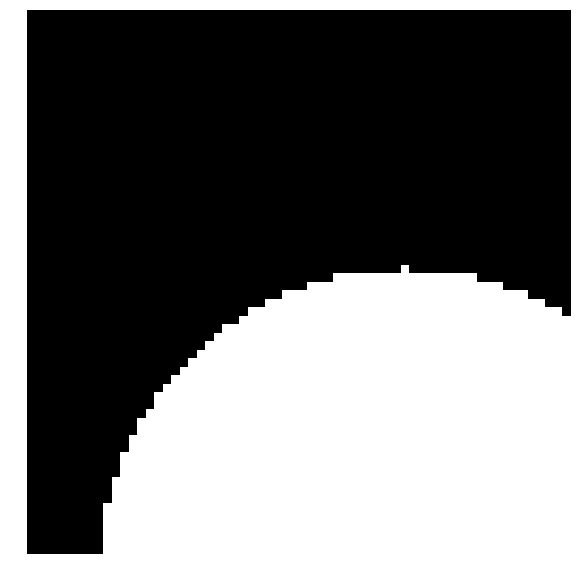

In [30]:
imm(trainY_binary[0,:,:,1].reshape([64,64]))

In [4]:
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(2298, 64, 64, 1) (2298, 64, 64, 1) (767, 64, 64, 1) (767, 64, 64, 1)


In [50]:
inputs = Input((64,64,1))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
print("conv1 shape:",conv1.shape)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
print("conv1 shape:",conv1.shape)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
print("pool1 shape:",pool1.shape)

# conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
# print("conv2 shape:",conv2.shape)
# conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
# print("conv2 shape:",conv2.shape)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
# print("pool2 shape:",pool2.shape)

# conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
# print("conv3 shape:",conv3.shape)
# conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
# print("conv3 shape:",conv3.shape)
# pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
# print("pool3 shape:",pool3.shape)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
print("conv4 shape:",conv4.shape)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
print("conv4 shape:",conv4.shape)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
print("pool4 shape:",pool4.shape)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
print("conv5 shape:",conv5.shape)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
print("conv6 shape:",conv6.shape)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
# merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
print("up6 shape:",up6.shape)
# conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
print("conv6 shape:",conv6.shape)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
print("conv6 shape:",conv6.shape)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
# merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
print("up7 shape:",up7.shape)
# conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
print("conv7 shape:",conv7.shape)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
print("up8 shape:",up8.shape)
# merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
# conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
print("conv8 shape:",conv8.shape)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
# merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

conv1 shape: (?, 64, 64, 64)
conv1 shape: (?, 64, 64, 64)
pool1 shape: (?, 32, 32, 64)
conv4 shape: (?, 32, 32, 512)
conv4 shape: (?, 32, 32, 512)
pool4 shape: (?, 16, 16, 512)
conv5 shape: (?, 16, 16, 1024)
conv6 shape: (?, 32, 32, 512)
up6 shape: (?, 32, 32, 512)
conv6 shape: (?, 32, 32, 512)
conv6 shape: (?, 32, 32, 512)
up7 shape: (?, 64, 64, 256)
conv7 shape: (?, 16, 16, 256)
up8 shape: (?, 32, 32, 128)
conv8 shape: (?, 32, 32, 128)


/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


RuntimeError: Graph disconnected: cannot obtain value for tensor Tensor("input_3:0", shape=(?, 64, 64, 1), dtype=float32) at layer "input_3". The following previous layers were accessed without issue: []

In [32]:
model.fit(trainX[:100],trainY[:100],batch_size=50,epochs=10,verbose=1,shuffle=True)

Epoch 1/10
100/100 [==============================] - 23s 234ms/step - loss: 0.6999 - acc: 0.5502
Epoch 2/10
100/100 [==============================] - 20s 202ms/step - loss: 0.6933 - acc: 0.6738
Epoch 3/10
100/100 [==============================] - 20s 201ms/step - loss: 0.6931 - acc: 0.6766
Epoch 4/10
100/100 [==============================] - 20s 202ms/step - loss: 0.6930 - acc: 0.6793
Epoch 5/10
100/100 [==============================] - 20s 204ms/step - loss: 0.6930 - acc: 0.6795
Epoch 6/10
100/100 [==============================] - 20s 200ms/step - loss: 0.6930 - acc: 0.6795
Epoch 7/10
100/100 [==============================] - 20s 200ms/step - loss: 0.6929 - acc: 0.6795
Epoch 8/10
100/100 [==============================] - 20s 199ms/step - loss: 0.6929 - acc: 0.6795
Epoch 9/10
100/100 [==============================] - 20s 201ms/step - loss: 0.6929 - acc: 0.6795
Epoch 10/10
100/100 [==============================] - 20s 199ms/step - loss: 0.6928 - acc: 0.6795


In [33]:
loss_and_metrics = model.evaluate(testX, testY, batch_size=12)

767/767 [==============================] - 43s 56ms/step


In [34]:
loss_and_metrics

[0.6928611940168806, 0.6447403780640026]

In [44]:
predicted_masks = model.predict(testX[:100],batch_size=1,verbose=1)

100/100 [==============================] - 5s 55ms/step


In [45]:
np.any(np.isin([1],predicted_masks))

False

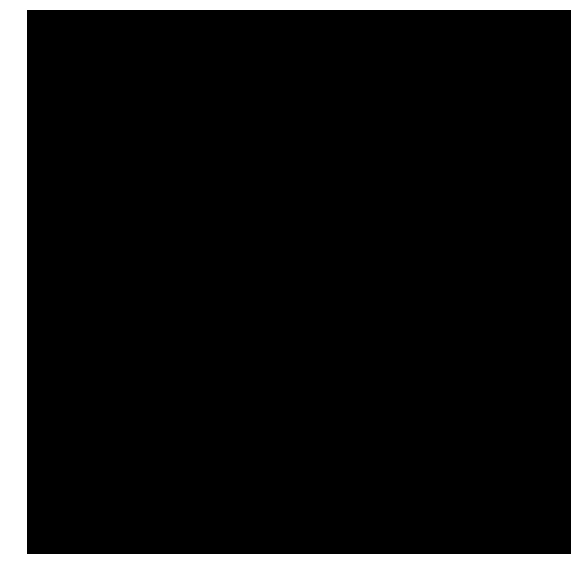

In [43]:
imm(predicted_masks[6,:,:,:].reshape([64,64]))

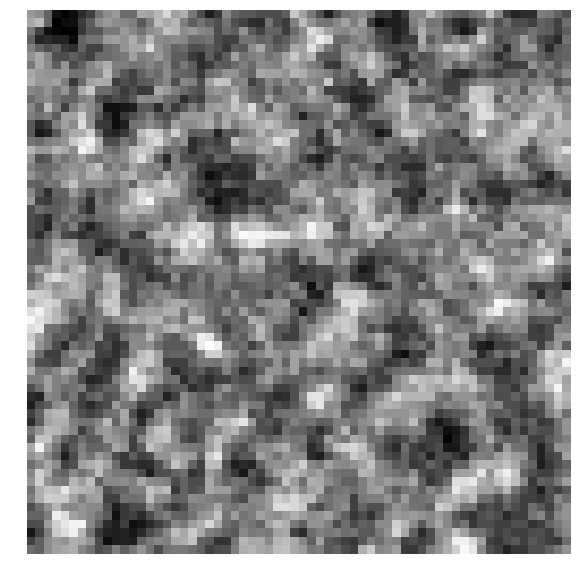

In [37]:
imm(testX[0,:,:,:].reshape([64,64]))

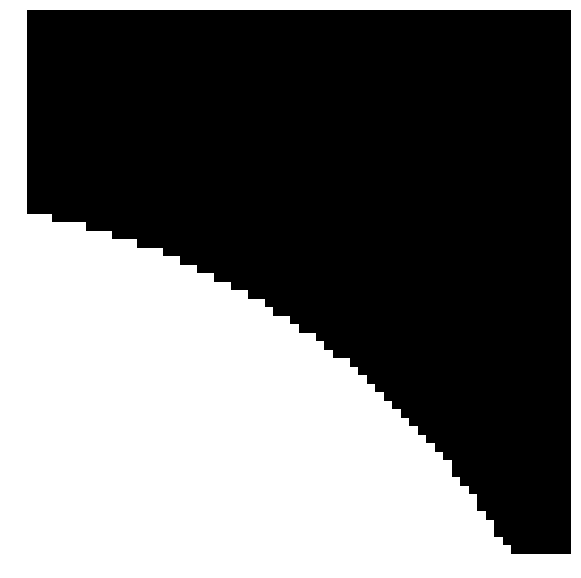

In [17]:
imm(testY[0,:,:,:].reshape([64,64]))

In [14]:
def reshape_for_viz(data_set,size,idx):
    img = data_set[idx,:,:,:].reshape(size)
    return img

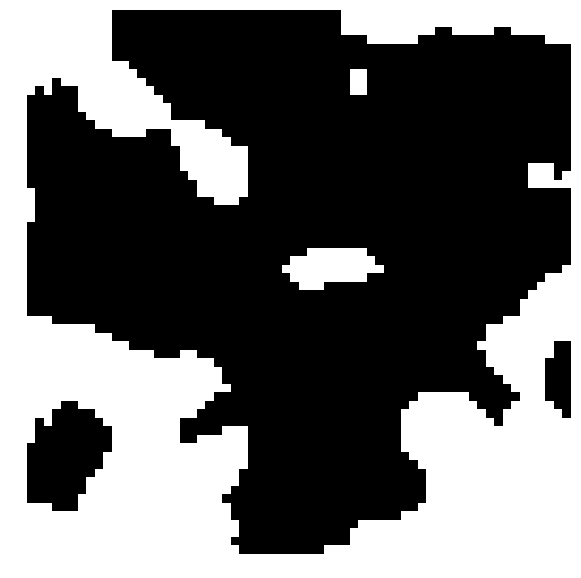

In [19]:
test_answer = reshape_for_viz(predicted_masks,(64,64),0)
test_answer[test_answer>0.35] = 1
test_answer[test_answer<=0.35] = 0
imm(test_answer)

In [62]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

In [63]:
def down(filters, input_):
    down_ = Conv2D(filters, (3, 3), padding='same')(input_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_ = Activation('relu')(down_)
    down_ = Conv2D(filters, (3, 3), padding='same')(down_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_)
    return down_pool, down_res

def up(filters, input_, down_):
    up_ = UpSampling2D((2, 2))(input_)
    up_ = concatenate([down_, up_], axis=3)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    return up_

In [65]:
def get_unet_1024(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)

    #down0b, down0b_res = down(8, inputs)
    down0a, down0a_res = down(24, inputs)
    down0, down0_res = down(64, down0a)
    down1, down1_res = down(128, down0)
    down2, down2_res = down(256, down1)
    down3, down3_res = down(512, down2)
    down4, down4_res = down(768, down3)
    
    center = Conv2D(768, (3, 3), padding='same')(down4)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)
    center = Conv2D(768, (3, 3), padding='same')(center)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)

    up4 = up(768, center, down4_res)
    up3 = up(512, up4, down3_res)
    up2 = up(256, up3, down2_res)
    up1 = up(128, up2, down1_res)
    up0 = up(64, up1, down0_res)
    up0a = up(24, up0, down0a_res)
    #up0b = up(8, up0a, down0b_res)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid', name='final_layer')(up0a)

    model = Model(inputs=inputs, outputs=classify)

    return model

In [79]:
DATA_PATH = directory
ASSETS_PATH = os.path.join(DATA_PATH, 'assets')
MODELS_PATH = os.path.join(ASSETS_PATH, 'models')
TENSORBOARD_PATH = os.path.join(ASSETS_PATH, 'tensorboard')

BATCH_SIZE = 2

# Training new model
ts = str(int(time.time()))
model_name = 'malhot'
num_epochs = 30
steps_per_epoch = int(len(trainY[:1000]) * 0.8/BATCH_SIZE)
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}-ts={}'.format(model_name,
                                                                          BATCH_SIZE,
                                                                          num_epochs,
                                                                          steps_per_epoch,
                                                                          ts)
tensorboard_loc = os.path.join(TENSORBOARD_PATH, run_name)
checkpoint_loc = os.path.join(MODELS_PATH, 'model-{}-weights.h5'.format(ts))

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=2, 
                              verbose=1, 
                              min_delta = 0.0001,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(checkpoint_loc,
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)
model = get_unet_1024((64,64,1))
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-4), metrics=[dice_coef])
print(model.summary())
model.fit(trainX[:1000],trainY[:1000],batch_size=50,epochs=10,verbose=1,shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_270 (Conv2D)             (None, 64, 64, 24)   240         input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 64, 64, 24)   96          conv2d_270[0][0]                 
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 64, 64, 24)   0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
conv2d_271

Epoch 1/10
1000/1000 [==============================] - 204s 204ms/step - loss: 1.2483 - dice_coef: 0.4663
Epoch 2/10
1000/1000 [==============================] - 194s 194ms/step - loss: 1.0428 - dice_coef: 0.5377
Epoch 3/10
1000/1000 [==============================] - 195s 195ms/step - loss: 0.8394 - dice_coef: 0.6232
Epoch 4/10
1000/1000 [==============================] - 194s 194ms/step - loss: 0.6760 - dice_coef: 0.6928
Epoch 5/10
1000/1000 [==============================] - 196s 196ms/step - loss: 0.5514 - dice_coef: 0.7481
Epoch 6/10
1000/1000 [==============================] - 195s 195ms/step - loss: 0.5147 - dice_coef: 0.7615
Epoch 7/10
1000/1000 [==============================] - 196s 196ms/step - loss: 0.4345 - dice_coef: 0.7975
Epoch 8/10
1000/1000 [==============================] - 196s 196ms/step - loss: 0.3954 - dice_coef: 0.8171
Epoch 9/10
1000/1000 [==============================] - 197s 197ms/step - loss: 0.3855 - dice_coef: 0.8210
Epoch 10/10
1000/1000 [==============

In [164]:
save_dir_pieces = directory.split('/')
save_dir = '/' +save_dir_pieces[0]
for idx, piece in enumerate(save_dir_pieces):
    if idx == 0:
        pass
    elif idx == len(save_dir_pieces)-1:
        pass
    else:
        save_dir += piece + '/'
       

save_dir

'/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/'

In [165]:
model_path = save_dir + 'models/second_trained_model_unet2.h5'

In [166]:
model.save(model_path)

In [167]:
model_path_weights = save_dir + 'models/second_trained_model_unet2_weights.h5'

In [168]:
model.save_weights(model_path_weights)

In [80]:
predicted_masks = model.predict(testX[:100],batch_size=1,verbose=1)

100/100 [==============================] - 6s 61ms/step


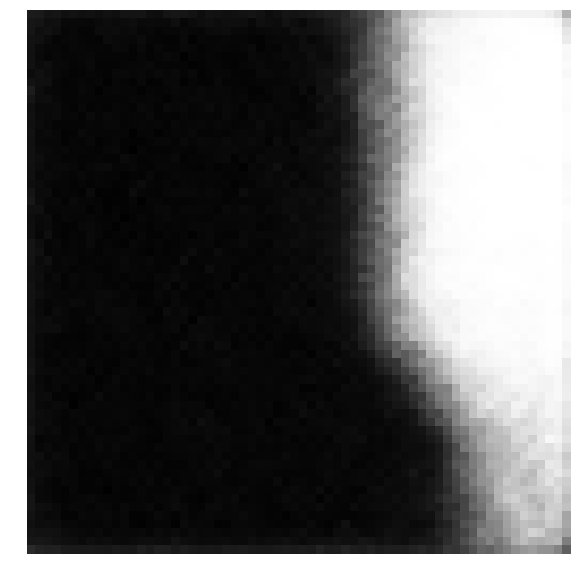

In [160]:
imm(predicted_masks[23,:,:,:].reshape([64,64]))

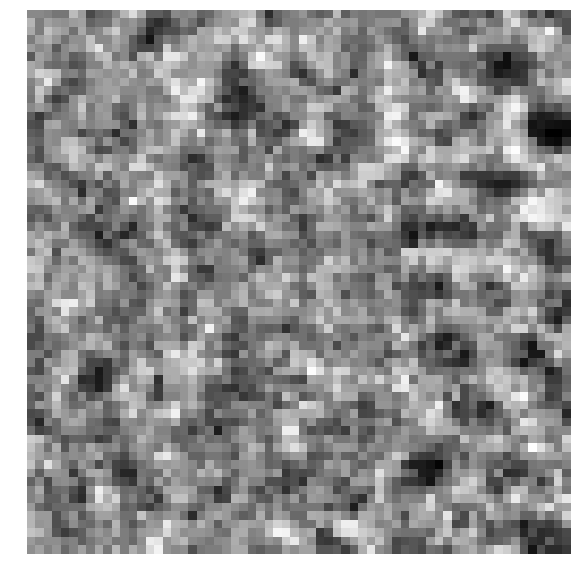

In [162]:
imm(testX[23,:,:,:].reshape([64,64]))

In [61]:
inputs = Input((64, 64, 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

NameError: name 'smooth' is not defined

In [57]:
model.fit(trainX,trainY,batch_size=100,epochs=10,verbose=1,shuffle=True)

Epoch 1/10
1500/2298 [==================>...........] - ETA: 43s - loss: 0.6730 - acc: 0.6541

KeyboardInterrupt: 